In [1]:
%matplotlib inline
import os
os.environ["MKL_NUM_THREADS"] = "4" 
os.environ["NUMEXPR_NUM_THREADS"] = "4" 
os.environ["OMP_NUM_THREADS"] = "4" 

# Imports
import numpy as np
import pandas as pd
import h5py
import re
import os
import matplotlib
import matplotlib.pyplot as plt
import operator
import seaborn as sns
from matplotlib.colors import ListedColormap
matplotlib.rcParams['pdf.fonttype'] = 42


# Tomography
import tomography
from tomography.utils import pad_to_cube, pad_to_square, shift_simmetrize
from brainmap import *
from helpers_designmatrix import *
from notebooks.data_loaders import *



# Sklearn, scipy
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.optimize import minimize, Bounds
import scipy.ndimage as sc
from sklearn.neighbors import NearestNeighbors
from skimage import io,feature,measure,transform,filters,exposure,morphology

# other libraries
from collections import defaultdict


np.random.seed(11)

In [2]:
# Load the mask
config = h5py.File("../../../../outputs/Mouse_config_reconstruction_09June2017_designed-Copy1.hdf5", mode="r") # retrieve mask file

mask = config["mask_g"][:]


# Loading Simulation Data

In [3]:


allen_brain_genes = np.load('../../resolution_violin/allen_brain_genes.npy')
ishloader = ISHLoader(root='../../../../brainmap/data', priority = ["coronal"])
# ishloader[allen_brain_genes[0]]
#Load files
all_pts = np.load('../../resolution_violin/all_pts.pkl', allow_pickle=True)
axis_0 = all_pts[0,:] / 3.6 + 17
axis_1 = all_pts[1,:] / 4 + 39
all_pts[0,:] = axis_0
all_pts[1,:] = axis_1
ref_pts = np.load('../../resolution_violin/ref_pts.pkl', allow_pickle=True)

# Transform points
pwat_all2ref = transform.PiecewiseAffineTransform()
pwat_all2ref.estimate(src=all_pts.T, dst=ref_pts.T)
pwat_ref2all = transform.PiecewiseAffineTransform()
pwat_ref2all.estimate(src=ref_pts.T, dst=all_pts.T)
pwat_all2ref_inv = pwat_all2ref.inverse
pwat_ref2all_inv = pwat_ref2all.inverse

allen_genes = {}
allen_genes_fraction3D = {}
graph = set_graph(mask, sigma=3)

for gene in allen_brain_genes:
    try:
        tmp = ishloader[gene]
    except:
        continue
        
    mask3D = shift_simmetrize(pad_to_cube((tmp[:]).astype(float)),1)
    mask2D = mask3D[33,:,:]
    tmp = rescale(mask2D, 2.35)
    all_wrapped = transform.warp(tmp, inverse_map =pwat_all2ref_inv,mode='constant',cval=np.NaN )
    all_wrapped[np.isnan(all_wrapped)] = 0
    if all_wrapped.mean() > 1e-5:
        all_wrapped = graph.dot(all_wrapped[np.where(mask >= 0.2)])
        allen_genes[gene] = all_wrapped
        #fraction = np.nanmax(mask2D) / np.nanpercentile(mask3D, 80)
        fraction = np.nanmax(mask2D) / np.nanmax(mask3D)
        allen_genes_fraction3D[gene] = fraction
        
allen_genes_list = list(allen_genes.keys())

# The Design Matrix <a class="anchor" id="chapter3"></a>

We will now create a customized design matrix. This design matrix exemplifies an example of a sampling scheme that 'punches' holes into the tissue. Below, the different colors would represent the different primary slices. Each primary slice has holes that are slightly shifted in the x and y directions as exemplified in the scatter plot.

Our goal is to convert this sampling scheme into a design matrix. We will then use the reconstructor class TomographerManualDesignMatrix which will allow us to feed our customized design matrix into the algorithm.

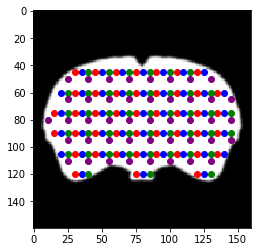

In [5]:
# Retrieve indexes of center points

mask_indexes = set(list(zip(np.argwhere(mask==1)[:,1], np.argwhere(mask==1)[:,0])))

b_centers = []


plt.imshow(mask, cmap='gray')

x = np.arange(0,len(mask), step=15)
y = np.arange(0,len(mask), step=15)
for x_ in x:
    for y_ in y:
        if (x_, y_) in mask_indexes:
            b_centers.append((x_,y_))
            plt.scatter(x_, y_, color='r')
x += 5

for x_ in x:
    for y_ in y:
        if (x_, y_) in mask_indexes:
            b_centers.append((x_,y_))
            plt.scatter(x_, y_, color='b')

x += 5

for x_ in x:
    for y_ in y:
        if (x_, y_) in mask_indexes:
            b_centers.append((x_,y_))
            plt.scatter(x_, y_, color='g')

y += 5

for x_ in x:
    for y_ in y:
        if (x_, y_) in mask_indexes:
            b_centers.append((x_,y_))
            plt.scatter(x_, y_, color='purple')


b_centers = np.array(b_centers)


In [6]:
# Find the nearest neighbors for all the center points

mask_idx = np.argwhere(mask >= 0.2)
nbrs = NearestNeighbors().fit(mask_idx)
graph = nbrs.kneighbors_graph(mask_idx, n_neighbors=50, 
                                            mode="distance").toarray()

graph = graph > 0.0 #(graph < 2.0) & (graph > 0.0)
graph = graph.astype(int)

In [7]:
A = np.zeros((len(b_centers), len(mask_idx)))

for i, b in enumerate(b_centers):
    idx = find_index(mask_idx, b_centers, i)

    # determine the neighboring pixels in 2D space
    neighboring_pixels = mask_idx[np.argwhere(graph[idx] == 1).flatten()]

    # determine what the indexes would be in the flattened mask
    A_indexes = find_index_neighbors(mask_idx, neighboring_pixels)

    A[i][A_indexes] =  1 # place indexes as 1

# average across the rows of A so that the neiboring pixels are equally sampled
A = A.T / A.sum(axis=1)
A = A.T

In [8]:
# create the configuration file
# angles_names = ['angle41', 'angle77', 'angle113', 'angle149', 'angle185']
angles_names = ['shift1', 'shift2', 'shift3']
first_points = np.zeros(len(angles_names))
width = 20


rec_conf = tomography.ReconstructionConfig(angles_names=angles_names,
                                           mask=mask,mask_thrs=0.2,
                                           reference_mask=mask,
                                           symmetry=False,
                                           masked_formulation=True,
                                           angles_values=[1,2,3],
                                           first_points=first_points,
                                           widths=[width,]*len(angles_names))


# Setting up Tomographer
tg = tomography.TomographerManualDesignMatrix(A=A, projection_lengths=[45,45,45,42])# initialize object
tg.load_cfg(rec_conf) # load the config file
tg.prepare_design() # load design matrices and set reconstructor object

In [9]:
gene = 'Lamp5'
b = np.dot(A, allen_genes[gene])
tg.reconstructor.r = 0.3 # set value for r


In [10]:
result = tg.reconstruct(b=b, alpha_beta="crossvalidation", 
                crossval_kwargs={'domain': [(0,4),(0.05,8)], 'logged_grid':False,                                               'extra_evals': 7,'style' : 'grid',                                                      'gradient_iter' : 5,
                                            'initial_grid_n': 5}
                                                            )

The set cost function is ignored! LCB acquisition does not make sense with cost.


Below we visualize the reconstructed image as well as a sample single sample, or 'hole', that was punched out in the sampling procedure.

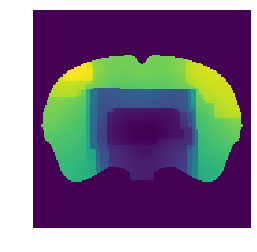

In [12]:
plt.imshow(result)
plt.axis('off')
plt.show()

(-0.5, 159.5, 159.5, -0.5)

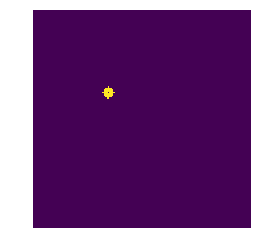

In [11]:
tmp_mask_idx = np.argwhere(mask.flatten() >= 0.2).flatten()
tmp = np.zeros(mask.shape).flatten()
tmp[tmp_mask_idx] = A[101]
plt.imshow(tmp.reshape(mask.shape))
plt.axis('off')